# Animal Spot Evaluation
## Important info
My name is David Kebert. This notebook is part of a [github repository](https://github.com/Davidkeebler/Orca-Detection) for a project that was done between February-April 2024. [Here's a link to my blog!](https://medium.com/@davidkebert1)

## Introduction
This notebook contains the code that was used to process log files and produce visualizations for the presentation. It should be run last, after the other three notebooks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is a script I generated with Claude 3 to extract the data I need from the log file. Thanks Claude!

In [ ]:
import re
import pandas as pd

# Read the log file
with open('/content/drive/MyDrive/ANIMAL-SPOT/Logs/TRAIN.log', 'r') as file:
    log_content = file.read()

# Define regular expressions to capture train and val data
train_pattern = r'train\|(\d+)\|loss:(\d+\.\d+)\|tp:(\d+\.\d+)\|tn:(\d+\.\d+)\|fp:(\d+\.\d+)\|fn:(\d+\.\d+)\|accuracy:(\d+\.\d+)\|f1:(\d+\.\d+)\|precision:(\d+\.\d+)\|TPR:(\d+\.\d+)\|FPR:(\d+\.\d+)\|lr:(\d+\.\d+e-\d+)\|t:(\d+\.\d+)'
val_pattern = r'val\|(\d+)\|loss:(\d+\.\d+)\|tp:(\d+\.\d+)\|tn:(\d+\.\d+)\|fp:(\d+\.\d+)\|fn:(\d+\.\d+)\|accuracy:(\d+\.\d+)\|f1:(\d+\.\d+)\|precision:(\d+\.\d+)\|TPR:(\d+\.\d+)\|FPR:(\d+\.\d+)\|t:(\d+\.\d+)'

# Extract data from the log and store it in lists
train_data = []
val_data = []

for match in re.finditer(train_pattern, log_content):
    train_data.append(match.groups())

for match in re.finditer(val_pattern, log_content):
    val_data.append(match.groups())

# Create dataframes
train_df = pd.DataFrame(train_data, columns=['epoch', 'loss', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'f1', 'precision', 'TPR', 'FPR', 'lr', 'time'])
val_df = pd.DataFrame(val_data, columns=['epoch', 'loss', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'f1', 'precision', 'TPR', 'FPR', 'time'])

# Convert columns to appropriate data types
train_df = train_df.astype({'epoch': int, 'loss': float, 'tp': float, 'tn': float, 'fp': float, 'fn': float, 'accuracy': float, 'f1': float, 'precision': float, 'TPR': float, 'FPR': float, 'lr': float, 'time': float})
val_df = val_df.astype({'epoch': int, 'loss': float, 'tp': float, 'tn': float, 'fp': float, 'fn': float, 'accuracy': float, 'f1': float, 'precision': float, 'TPR': float, 'FPR': float, 'time': float})

# Print the dataframes
print("Training Data:")
print(train_df)
print("\nValidation Data:")
print(val_df)

Training Data:
    epoch   loss     tp     tn     fp     fn  accuracy     f1  precision  \
0       0  0.465  296.0  760.0  110.0  174.0     0.788  0.676      0.729   
1       1  0.360  346.0  769.0  101.0  124.0     0.832  0.755      0.774   
2       2  0.324  374.0  769.0  101.0   96.0     0.853  0.792      0.787   
3       3  0.303  384.0  781.0   89.0   86.0     0.869  0.814      0.812   
4       4  0.287  390.0  792.0   78.0   80.0     0.882  0.832      0.833   
5       5  0.269  391.0  804.0   67.0   78.0     0.892  0.844      0.854   
6       6  0.274  389.0  806.0   65.0   80.0     0.892  0.843      0.857   
7       7  0.237  399.0  809.0   61.0   71.0     0.901  0.858      0.867   
8       8  0.212  404.0  828.0   42.0   66.0     0.919  0.882      0.906   
9       9  0.114  447.0  853.0   18.0   22.0     0.970  0.957      0.961   
10     10  0.070  458.0  859.0   10.0   13.0     0.983  0.976      0.979   
11     11  0.054  459.0  865.0    5.0   11.0     0.988  0.983      0.989 

Perfect! Now that we have the data in a tabular format, we can start to make graphs and do some analysis. Let's plot the model's accuracy (the main statistic used by the framework to evaluate the model during training) to get a better idea of how training proceeded.

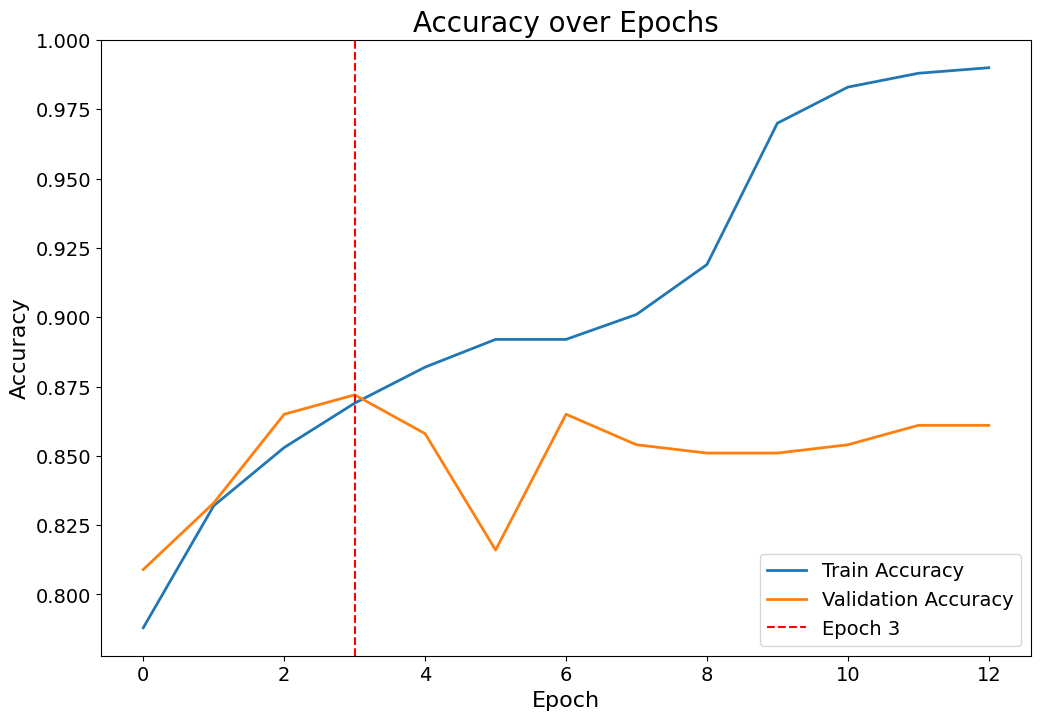

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot accuracy over epochs
plt.figure(figsize=(12, 8))
plt.plot(train_df['epoch'], train_df['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(val_df['epoch'], val_df['accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=3, linestyle='--', color='r', label='Epoch 3')  # Add dotted line at epoch 3

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy over Epochs', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can clearly see that validation accuracy hit its highest point at epoch 3, after which it quickly declined. This is evidence that the model started overfitting after epoch 3.

In future training runs, we might address this by lowering the learning rate. It was already very low (the lowest value recommended by the animal-spot github and config file), but it is possible that we could find a valley of low loss that takes the accuracy even higher if the learning rate was lower and we went more epochs before overfitting. Either way, the framework reverted to the 3rd epoch checkpoint and used it in the creation of the final animal-spot.pk file.

Now, let's make a confusion matrix to dive deeper into the evaluation statistics of the model in the 3rd epoch!

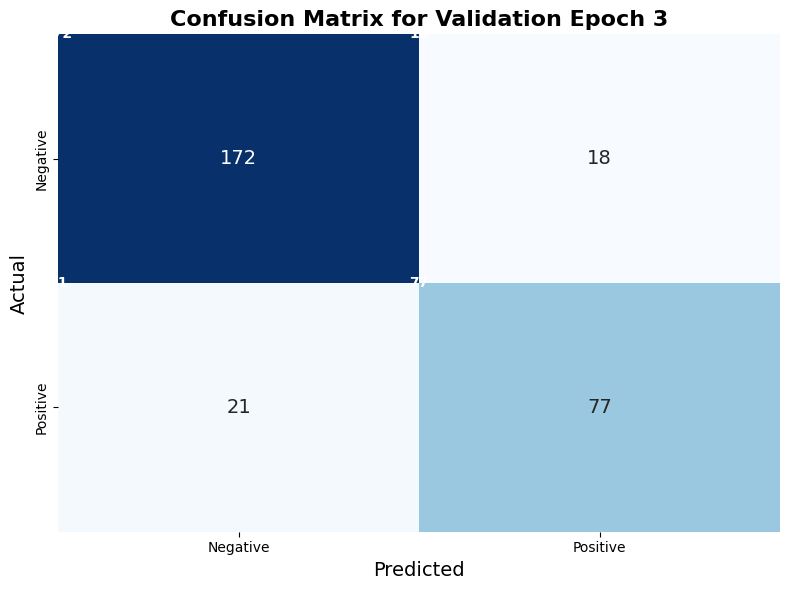

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the values for the 3rd validation epoch
epoch = 2  # 3rd epoch has index 2 in the dataframe
tn, fp, fn, tp = val_df.iloc[epoch, 3:7].astype(int)

# There is a strange error that is causig tp = 0 so I set it manually here. This value is visible in the table above and is correct.
tp = 77

# Create the confusion matrix
cm = np.array([[tn, fp], [fn, tp]])

# Define labels
labels = ['Negative', 'Positive']

# Define color palette
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                 xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"fontsize": 14})

# Customize the plot
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_title(f'Confusion Matrix for Validation Epoch {epoch+1}', fontsize=16, fontweight='bold')

# Add value labels
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

That's looking great! It even has a color scheme that's appropriate for my presentation, which you love to see.

We can see above that there were about the samne amount of False Negatives and False Positives in this evaluation. It is worth noting that the threshold for detecting a signal is significantly higher in train/test/val than the value I manually selected for prediction. This likely contributes to the number of false negatives detected.

Because of the amount of raw data available to run prediction on with this model, these statistics seem to me to be acceptable.
The model misclassified about 20% of the true positive clips, but it is likely that these were misidentified due to low volume/high background noise and are not good candidates for the clustering process I want to run later.
Only about 10% of the True Negative clips were misidentified as positives. The fact that this is a small proportion of all the negatives is good, as we want to include as little noise in the target data as possible. I conjecture based on observations made during predictions that most of these false positives are empty or extremely low-noise segments of the data. If this was shown to be the case, it would be easy to write a program that detects and rules out these false positives based on their volume.

### Conclusion
In this notebook we:
- Parsed the training output log into a dataframe
- Created a graph that shows the training and validation accuracy of the model as training progressed
- Made a confusion matrix that shows the quantity of tp, fp, tn, and fns in the validation of the epoch that was used to create the final model
- Analyzed both of these visualizations to get insight into how subsequent training runs can be improved